In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE
import re

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

## Read in payments joined on doctor_ratings table
Don't look at doctors that are not in `doctor_ratings` table.

In [36]:
q = """SELECT doctor_ratings.npi, doctor_ratings.recommended_by_doctors, 
                doctor_ratings.board_certification, doctor_ratings.graduation_year,
                doctor_ratings.internship_residency, doctor_ratings.confidence, doctor_ratings.name, 
                doctor_ratings.relative_volume,
                payments.hcpcs_code, payments.hcpcs_description, 
                payments.line_srvc_cnt, payments.bene_unique_cnt, payments.bene_day_srvc_cnt,
                payments.average_medicare_standard_amt,
                payments.hcpcs_drug_indicator, payments.nppes_provider_zip,
                payments.nppes_provider_city, payments.nppes_provider_state
        FROM payments
        JOIN doctor_ratings 
        ON (payments.npi = doctor_ratings.npi)"""
doctors = pd.read_sql_query(q, con=con)

In [37]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67029 entries, 0 to 67028
Data columns (total 18 columns):
npi                              67029 non-null object
recommended_by_doctors           67029 non-null object
board_certification              67029 non-null object
graduation_year                  67029 non-null object
internship_residency             67029 non-null object
confidence                       67029 non-null int64
name                             67029 non-null object
relative_volume                  67029 non-null object
hcpcs_code                       67029 non-null object
hcpcs_description                67029 non-null object
line_srvc_cnt                    67029 non-null float64
bene_unique_cnt                  67029 non-null float64
bene_day_srvc_cnt                67029 non-null float64
average_medicare_standard_amt    67029 non-null float64
hcpcs_drug_indicator             67029 non-null object
nppes_provider_zip               67029 non-null object
nppes_pr

In [39]:
## convert dtypes of some columns
doctors['recommended_by_doctors'] = pd.to_numeric(doctors['recommended_by_doctors'], errors='coerce')
doctors['confidence'] = pd.to_numeric(doctors['confidence'], errors='coerce')
doctors['relative_volume'] = pd.Categorical(doctors['relative_volume'], 
                                            categories = ['Lower volume','Medium volume','Higher volume'], 
                                            ordered=True)

In [40]:
doctors.describe()

/home/cathy/miniconda3/envs/medicare_provider_util_payment/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,recommended_by_doctors,confidence,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt
count,6171.000000,67029.000000,67029.000000,67029.000000,67029.000000,67029.000000
mean,5.875871,3.444434,165.959077,76.569186,105.900252,154.174843
std,3.120563,0.780444,490.155940,99.306828,169.177159,304.803994
min,3.000000,3.000000,11.000000,11.000000,11.000000,0.010000
25%,NaN,3.000000,22.000000,18.000000,21.000000,23.300000
50%,NaN,3.000000,49.000000,37.000000,44.000000,34.820000
75%,NaN,4.000000,142.000000,95.000000,119.000000,80.250000
max,29.000000,5.000000,41901.000000,1745.000000,7029.000000,1684.890000


In [41]:
doctors.head()

,npi,recommended_by_doctors,board_certification,graduation_year,internship_residency,confidence,name,relative_volume,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt,hcpcs_drug_indicator,nppes_provider_zip,nppes_provider_city,nppes_provider_state
0,1003029034,NaN,Orthopaedic Surgery,2004,,3,"Bowen, Joseph Marshall",Medium volume,20610,Aspiration and/or injection of large joint or joint capsule,70.0,56.0,68.0,42.28,N,838545217,POST FALLS,ID
1,1003029034,NaN,Orthopaedic Surgery,2004,,3,"Bowen, Joseph Marshall",Medium volume,26055,Incision of tendon covering,13.0,11.0,11.0,226.84,N,838545217,POST FALLS,ID
2,1003029034,NaN,Orthopaedic Surgery,2004,,3,"Bowen, Joseph Marshall",Medium volume,27130,Replacement of thigh bone and hip joint prosthesis,31.0,30.0,31.0,1093.32,N,838545217,POST FALLS,ID
3,1003029034,NaN,Orthopaedic Surgery,2004,,3,"Bowen, Joseph Marshall",Medium volume,27447,Repair of knee joint,16.0,16.0,16.0,1093.06,N,838545217,POST FALLS,ID
4,1003029034,NaN,Orthopaedic Surgery,2004,,3,"Bowen, Joseph Marshall",Medium volume,64721,Release and/or relocation of median nerve of hand,22.0,18.0,22.0,339.55,N,838545217,POST FALLS,ID


In [42]:
## Number of distinct npis (doctors) in doctors dataframe
doctors.drop_duplicates(['npi']).shape

(3535, 18)

## Counts per code

In [51]:
# How many distinct hcpcs codes are there in the dataset?
doctors['hcpcs_code'].drop_duplicates().size

630

In [66]:
# How many times does each code occur (as a row) in the table?
counts_per_code = (doctors.groupby('hcpcs_code').
                       count()['npi'].
                       reset_index(name='count'))
counts_per_code.head()

,hcpcs_code,count
0,0055T,1
1,10160,3
2,11012,1
3,11042,7
4,11043,2


In [81]:
(doctors.loc[doctors.hcpcs_code == '20610', ['npi','hcpcs_code']].
 groupby('npi').
 count()).sort_values('hcpcs_code', ascending=False).head(5)

,hcpcs_code
npi,
1992926281,2
1669490405,2
1326153925,2
1215008602,2
1093786972,2


In [80]:
## It looks like doctors can have more than 1 claim row for the hcpcs_code (the line_srvc_cnt is different
## between rows for the same npi, hcpcs_code).
(doctors.query("hcpcs_code == '20610'")
        .query("npi == '1215008602'"))

,npi,recommended_by_doctors,board_certification,graduation_year,internship_residency,confidence,name,relative_volume,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt,hcpcs_drug_indicator,nppes_provider_zip,nppes_provider_city,nppes_provider_state
14759,1215008602,NaN,Orthopaedic Surgery,1981,"Akron City Hospital, Akron, OH; Akron City Hospital, Akron, OH",3,"Pentz, Anthony S.",Higher volume,20610,Aspiration and/or injection of large joint or joint capsule,24.0,23.0,23.0,20.86,N,447183603,CANTON,OH
14760,1215008602,NaN,Orthopaedic Surgery,1981,"Akron City Hospital, Akron, OH; Akron City Hospital, Akron, OH",3,"Pentz, Anthony S.",Higher volume,20610,Aspiration and/or injection of large joint or joint capsule,319.0,152.0,256.0,39.18,N,447183603,CANTON,OH


In [70]:
## Why does a particular code appear more times than there are doctors?  Shouldn't there be at maximum one
## at most one claim per code per doctor, so the max count should equal the number of distinct npi's?
doctors.loc[doctors.hcpcs_code == '20610','hcpcs_code'].shape

(3694,)

In [67]:
pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(doctors[['hcpcs_code', 'hcpcs_description','hcpcs_drug_indicator']].
                                         drop_duplicates('hcpcs_code'),
                                         on='hcpcs_code')
                                   .sort_values('count', ascending=False))
counts_per_code.head(20)

,hcpcs_code,count,hcpcs_description,hcpcs_drug_indicator
32,20610,3694,Aspiration and/or injection of large joint or joint capsule,N
528,99213,3602,"Established patient office or other outpatient visit, typically 15 minutes",N
523,99203,3257,"New patient office or other outpatient visit, typically 30 minutes",N
174,27447,2837,Repair of knee joint,N
529,99214,2735,"Established patient office or other outpatient, visit typically 25 minutes",N
527,99212,2476,"Established patient office or other outpatient visit, typically 10 minutes",N
329,73030,2400,"X-ray of shoulder, minimum of 2 views",N
346,73510,2278,"X-ray of ribs of one side of body, minimum of 2 views",N
352,73562,2244,"X-ray of knee, 3 views",N
351,73560,2151,"X-ray of knee, 1 or 2 views",N


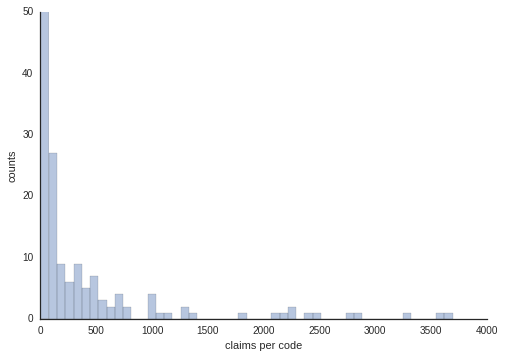

In [68]:
g = sns.distplot(counts_per_code['count'], kde=False)
g.set(ylim=(0,50), xlabel='claims per code', ylabel='counts')
sns.despine()

## Describe each doctor by a feature vector of line service counts

In [83]:
## skirt the double hcpcs_code claim problem by dropping duplicate rows of npi, hcpcs_code for now.

by_npi = (doctors[['npi','hcpcs_code','line_srvc_cnt']].
          drop_duplicates(['npi','hcpcs_code']).
          pivot(index='npi', values = 'line_srvc_cnt', columns='hcpcs_code').
         fillna(value=0))

by_npi.head(4)

hcpcs_code,0055T,10160,11012,11042,11043,11044,11047,11055,11056,11406,...,Q4038,Q4045,Q4046,Q4049,Q9960,Q9961,Q9962,Q9965,Q9966,Q9967
npi,,,,,,,,,,,,,,,,,,,,,
1003029034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003802646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003808098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003809484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
## normalize columns of by_npi
from sklearn import preprocessing
X_raw = by_npi.as_matrix()
X_normed = preprocessing.scale(X_raw)

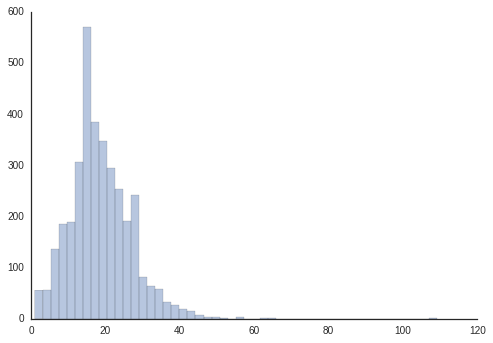

In [84]:
## How many different codes have been claimed per doctor?  Plot distribution

number_of_different_drug_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot(number_of_different_drug_codes_per_doctor, kde=False)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()

## tSNE of doctors in medicare claims space

In [126]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_raw)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3535
[t-SNE] Computed conditional probabilities for sample 2000 / 3535
[t-SNE] Computed conditional probabilities for sample 3000 / 3535
[t-SNE] Computed conditional probabilities for sample 3535 / 3535
[t-SNE] Mean sigma: 75.069369
[t-SNE] Iteration 25: error = 1.6148629, gradient norm = 0.0085662
[t-SNE] Iteration 50: error = 1.5117563, gradient norm = 0.0062269
[t-SNE] Iteration 75: error = 1.1830142, gradient norm = 0.0028350
[t-SNE] Iteration 100: error = 1.1237938, gradient norm = 0.0024509
[t-SNE] Error after 100 iterations with early exaggeration: 1.123794
[t-SNE] Iteration 125: error = 1.0315115, gradient norm = 0.0020095
[t-SNE] Iteration 150: error = 1.0044000, gradient norm = 0.0018633
[t-SNE] Iteration 175: error = 0.9981005, gradient norm = 0.0018345
[t-SNE] Iteration 200: error = 0.9964073, gradient norm = 0.0018269
[t-SNE] Itera

In [127]:
X_embedded_normed = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_normed)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3535
[t-SNE] Computed conditional probabilities for sample 2000 / 3535
[t-SNE] Computed conditional probabilities for sample 3000 / 3535
[t-SNE] Computed conditional probabilities for sample 3535 / 3535
[t-SNE] Mean sigma: 1.095881
[t-SNE] Iteration 25: error = 1.2400327, gradient norm = 0.0152663
[t-SNE] Iteration 50: error = 1.1973473, gradient norm = 0.0123921
[t-SNE] Iteration 75: error = 1.0341245, gradient norm = 0.0064735
[t-SNE] Iteration 100: error = 0.9991121, gradient norm = 0.0069801
[t-SNE] Error after 100 iterations with early exaggeration: 0.999112
[t-SNE] Iteration 125: error = 0.9421781, gradient norm = 0.0054380
[t-SNE] Iteration 150: error = 0.9241250, gradient norm = 0.0051178
[t-SNE] Iteration 175: error = 0.9180945, gradient norm = 0.0050538
[t-SNE] Iteration 200: error = 0.9160691, gradient norm = 0.0058579
[t-SNE] Iterat

In [128]:
## make color codes 
## confidence, relative_volume, years since graduation, recommended by doctors, board_certification (y/n)
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(doctors.
                     drop_duplicates(['npi'])[['npi','confidence','relative_volume',
                                              'recommended_by_doctors','graduation_year',
                                              'board_certification']]
                    )
              )
color_codes.head()

,npi,confidence,relative_volume,recommended_by_doctors,graduation_year,board_certification
0,1003029034,3,Medium volume,NaN,2004,Orthopaedic Surgery
1,1003802646,3,Medium volume,NaN,,Orthopaedic Surgery
2,1003808098,3,Medium volume,NaN,1981,Orthopaedic Surgery
3,1003809484,5,Higher volume,NaN,1997,Orthopaedic Surgery
4,1003811514,3,Lower volume,NaN,1978,Orthopaedic Surgery


In [129]:
## for each column, are there any NAs?
color_codes.apply(lambda x: x.isnull().any(), axis=0)

npi                       False
confidence                False
relative_volume            True
recommended_by_doctors     True
graduation_year           False
board_certification       False
dtype: bool

In [130]:
## How many rows are missing graduation_year?
color_codes['graduation_year'].map(lambda x: x=='').sum()

172

In [131]:
## process color codes
color_codes['board_certification'] = (color_codes['board_certification'].
                                      map(lambda x: x != '')) # board-certified => True
#color_codes = (color_codes.
               #assign(yrs_since_graduation = lambda x: (2014 - int(x.graduation_year)) if x.graduation_year != '' else np.NaN).
#               assign(is_recommended = lambda x: True if np.isnan(x.recommended_by_doctors) else False))
color_codes.head()

,npi,confidence,relative_volume,recommended_by_doctors,graduation_year,board_certification
0,1003029034,3,Medium volume,NaN,2004,True
1,1003802646,3,Medium volume,NaN,,True
2,1003808098,3,Medium volume,NaN,1981,True
3,1003809484,5,Higher volume,NaN,1997,True
4,1003811514,3,Lower volume,NaN,1978,True


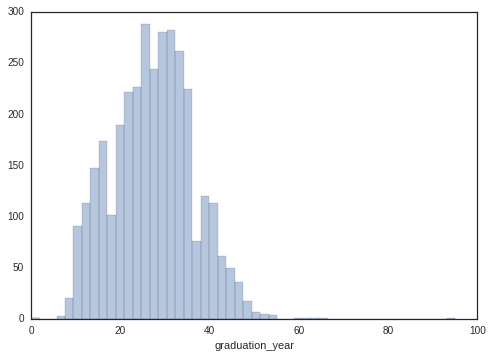

In [151]:
graduation_yr_missing = (color_codes['graduation_year'] == '')
yrs_since_graduation = (color_codes.loc[~graduation_yr_missing, 
                                      'graduation_year'].
                        astype(int).map(lambda x: 2014 - x))
sns.distplot(yrs_since_graduation, kde=False)

In [152]:
yrs_since_graduation.describe()
## the maximum years since graduation seems impossible

count    3363.000000
mean       27.250372
std         9.079187
min         0.000000
25%        21.000000
50%        27.000000
75%        34.000000
max        95.000000
Name: graduation_year, dtype: float64

In [155]:
## len(yrs_since_graduation) != len(X_embedded)

#sc = plt.scatter(X_embedded[~graduation_yr_missing,0], 
#                 X_embedded[~graduation_yr_missing,1], 
#                 c = yrs_since_graduation, cmap='YlOrRd')

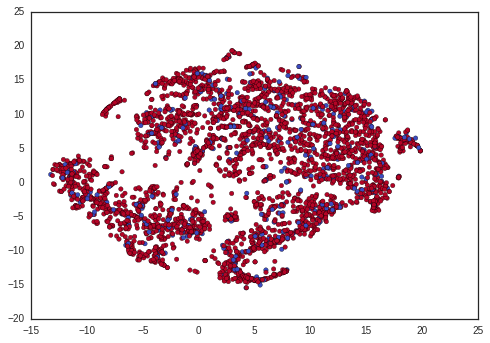

In [138]:
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color_codes['board_certification'], cmap='coolwarm')

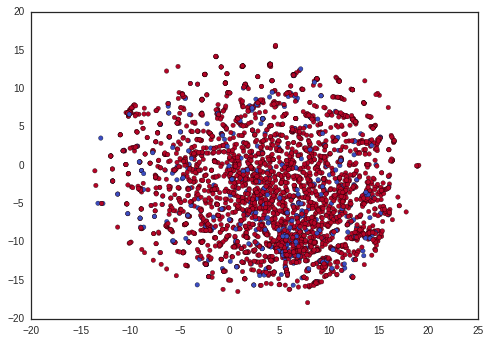

In [141]:
sc = plt.scatter(X_embedded_normed[:,0], X_embedded_normed[:,1], c = color_codes['board_certification'], cmap='coolwarm')

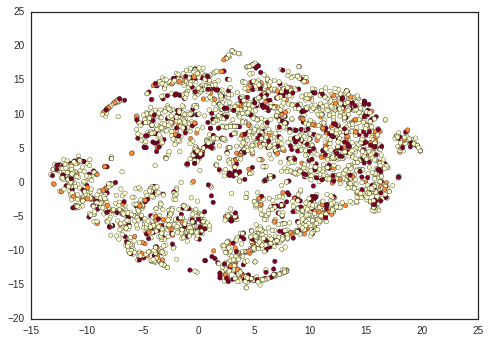

In [140]:
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                 c = color_codes['confidence'], cmap='YlOrRd')

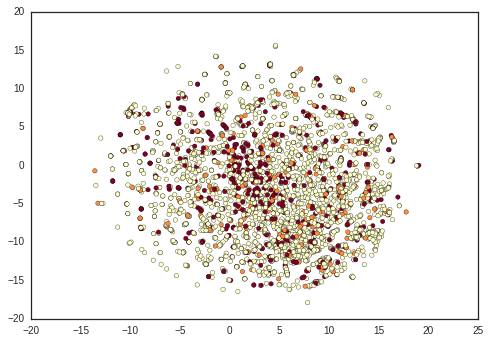

In [142]:
sc = plt.scatter(X_embedded_normed[:,0], X_embedded_normed[:,1], 
                 c = color_codes['confidence'], cmap='YlOrRd')

## PCA plots on normalized data

In [159]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
pca.fit(X_normed)

In [161]:
pca.explained_variance_ratio_

array([ 0.0812732 ,  0.02322926,  0.019381  ])

In [162]:
pca.components_

array([[  1.37326101e-04,   1.25740917e-03,   4.87932898e-05, ...,
          4.74825075e-05,  -7.29882385e-05,   1.39216890e-01],
       [ -7.00831093e-03,  -6.45088575e-02,  -2.06376256e-02, ...,
         -2.33398557e-03,   1.68114224e-04,   9.50156586e-03],
       [  3.03792680e-03,   2.30896547e-02,   5.23393405e-03, ...,
         -1.47057968e-03,  -6.45966519e-04,   7.83068498e-03]])

In [165]:
## locate the index of the largest absolute value in principle component 1
max_element_pc1 = np.argmax(np.absolute(pca.components_[0]))
max_element_pc1

283

In [166]:
## which hcpcs_code does 283 correspond to?
by_npi.columns.values[283]

'70470'

In [173]:
## only 1 doctor made a claim, with line_srvc_cnt = 29, compared to all other claims
## with line_srvc_cnt = 0 => largest axis of variation
doctors[doctors.hcpcs_code == '70470']

,npi,recommended_by_doctors,board_certification,graduation_year,internship_residency,confidence,name,relative_volume,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_standard_amt,hcpcs_drug_indicator,nppes_provider_zip,nppes_provider_city,nppes_provider_state
66030,1982656450,NaN,Orthopaedic Surgery,1990,,3,"Noble, John Wallace",Higher volume,70470,CT scan head or brain before and after contrast,29.0,29.0,29.0,102.08,N,706055362,LAKE CHARLES,LA


In [156]:
X_pca = pca.transform(X_normed)

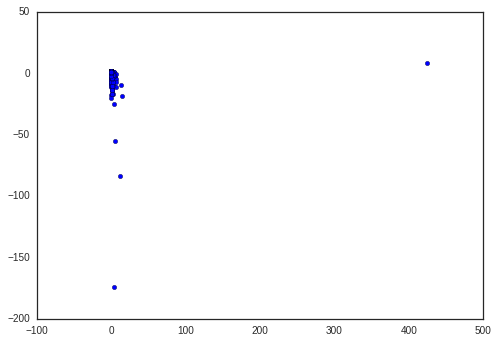

In [158]:
plt.scatter(X_pca[:,0], X_pca[:,1])

## Try dropping the column and redo PCA

## k-means clustering 

In [ ]:
## tSNE plots color coded according to physician level characteristics

plt.rcParams['figure.figsize'] = (15.0, 15.0)

## color code values to run through
color_col_idx = list(range(1,5))+[7]
#color_col_idx = list(range(1,5))

for i, color_idx in enumerate(color_col_idx):
    plt.subplot(3,2, i+1)
    sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                     c=np.log(color_codes.iloc[:, color_idx] + 1.0), cmap='YlOrRd')
    plt.colorbar(sc)
    plt.title(color_codes.columns.values[color_idx])

In [ ]:
if con:
    con.close()